In [1]:
import numpy as np
import pylab as plt
import pickle
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm
import torchvision
import torch
import torch.nn as nn
from transformers import ConvNextImageProcessor
import torch.nn.functional as F
import h5py



/global/homes/a/ashodkh/.conda/envs/my_torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path = '/global/cfs/cdirs/m4236/cosmosweb/catalogs/hsc_jwst_matched_with_images_high_snr'
f = h5py.File(file_path, 'r')

list(f.keys())

['Confidence_level',
 'bulge_radius',
 'dec',
 'dec_specz',
 'disk_radius',
 'flux_err-cal_model_cfht-u',
 'flux_err-cal_model_f115w',
 'flux_err-cal_model_f150w',
 'flux_err-cal_model_f277w',
 'flux_err-cal_model_f444w',
 'flux_err-cal_model_hsc-g',
 'flux_err-cal_model_hsc-i',
 'flux_err-cal_model_hsc-r',
 'flux_err-cal_model_hsc-y',
 'flux_err-cal_model_hsc-z',
 'flux_model_cfht-u',
 'flux_model_f115w',
 'flux_model_f150w',
 'flux_model_f277w',
 'flux_model_f444w',
 'flux_model_hsc-g',
 'flux_model_hsc-i',
 'flux_model_hsc-r',
 'flux_model_hsc-y',
 'flux_model_hsc-z',
 'hsc_images',
 'id_specz_khostovan25',
 'jwst_images',
 'lephare_photozs',
 'lp_age',
 'lp_mass',
 'lp_sfr',
 'lp_ssfr',
 'lp_type',
 'lp_zpdf_l68',
 'lp_zpdf_u68',
 'mag_model_cfht-u',
 'mag_model_f115w',
 'mag_model_f150w',
 'mag_model_f277w',
 'mag_model_f444w',
 'mag_model_hsc-g',
 'mag_model_hsc-i',
 'mag_model_hsc-r',
 'mag_model_hsc-y',
 'mag_model_hsc-z',
 'photoz',
 'ra',
 'ra_specz',
 'specz']

In [21]:
n = 5000
telescope = 'jwst'
if telescope == 'hsc':
    images = f[f'{telescope}_images'][:n,[1,2,4]].astype(np.float32)
elif telescope == 'jwst':
    images = f[f'{telescope}_images'][:n,[0,1,2]].astype(np.float32)   


In [22]:
images.shape

(5000, 3, 128, 128)

In [23]:
quantiles = np.quantile(images, q=(0.01,0.99), axis=(0,2,3)).astype(np.float32)
print(quantiles.shape)
print(quantiles)


(2, 3)
[[-0.22025758 -0.2593931  -0.10691117]
 [ 1.4456813   1.870461    2.341528  ]]


In [24]:
def normalize_img(img, m, M):
    return np.clip((img - m[None,:,None,None]) / (M[None,:,None,None] - m[None,:,None,None]), 0, 1)
    

In [39]:
m = quantiles[0]
M = quantiles[1]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
imagenet_mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)
imagenet_std  = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)

upsample = True
def to_convnext_batch(batch_np, upsample):
    x = torch.from_numpy(batch_np).to(device=device, non_blocking=True)  # B,C,H,W
    x = (x - imagenet_mean) / imagenet_std
    if upsample:
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)        

    return x
    

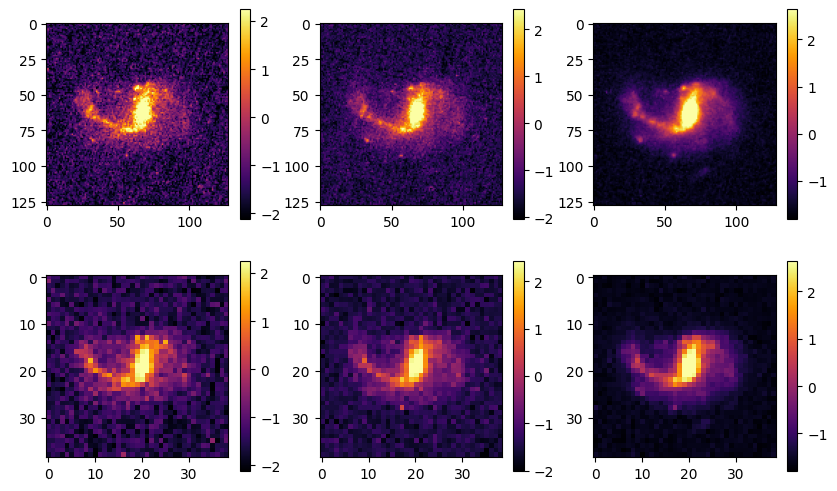

In [40]:
test_img = images[0:1]
converted_img = to_convnext_batch(normalize_img(test_img,m,M), upsample=False).detach().cpu().numpy()
upsampled_img = to_convnext_batch(normalize_img(test_img,m,M), upsample=True).detach().cpu().numpy()

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,6))

for j in range(3):
    sd = ax[0,j].imshow(converted_img[0,j,:,:], cmap='inferno')
    fig.colorbar(sd, ax=ax[0,j])
    #ax[0,j].set_xticks([])
    #ax[0,j].set_yticks([])

    sd = ax[1,j].imshow(upsampled_img[0,j,:,:], cmap='inferno')
    fig.colorbar(sd, ax=ax[1,j])
    #ax[1,j].set_xticks([])
    #ax[1,j].set_yticks([])
    

In [50]:
model_size = 'large'
model = torchvision.models.convnext_large(weights="DEFAULT")
model.classifier = nn.Identity()
model.to(device).eval();


In [51]:
batch = 200

with torch.no_grad():
    dummy = torch.zeros(1, 3, images.shape[2], images.shape[3], device=device)
    output_dim = model(dummy).shape[1]

embeddings = np.zeros((n, output_dim), dtype=np.float32)

with torch.no_grad():
    for i in tqdm(range(0, n, batch)):
        end = min(i + batch, n)
        sl = slice(i, end)
        # hsc_batch_images = processor.preprocess(torch.tensor(_norm(hsc_images[sl,[0,1,3],:,:], hsc_m, hsc_M), device=device), return_tensors='pt')['pixel_values']
        # jwst_batch_images = processor.preprocess(torch.tensor(_norm(jwst_images[sl,[0,1,2],:,:], jwst_m, jwst_M), device=device), return_tensors='pt')['pixel_values']
    
        batch_images = to_convnext_batch(normalize_img(images[sl], m, M), upsample=upsample)

        embeddings[sl] = model(batch_images).detach().cpu().numpy().squeeze()
        

100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


In [52]:
dir_out = '/pscratch/sd/a/ashodkh/platonic_universe/embeddings/'
if upsample:
    np.save(dir_out + f'embeddings_{telescope}_{n}_convnext{model_size}_upsampled_images', embeddings)
else:
    np.save(dir_out + f'embeddings_{telescope}_{n}_convnext{model_size}', embeddings)

